### Creating representative observations for Clyfar and the Uinta Basin
We will load 2022/2023 and reduce observation set to daily representative values.

We seek single values for:
* Wind speed (mid-upper percentile to ignore thunderstorm gusts etc)
* MSLP (calibrate to find something not buggered by altitude calculations)
* Insolation (I was using "near zenith mean" for 10-14: around solar noon)
* Snow depth (data is sparse, so we need to make most of COOP sites once a day)
* NEW: pseudo-lapse-rate, using temperature and altitude values up the slope to estimate a lapse rate and perhaps detect a shallow cold pool
* NEW: soil temperature, which may be correlated with snow-melt and hence more difficult inversion formation

We can then start to relate things day-to-day. Note our days will be local, meaning offset from UTC of -6 or -7 depending on daylight savings.

In [1]:
import os

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

from obs.obsdata import ObsData

/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/accessors.py:28: UserWarning: map making not available without Brian's cartopy_tools
  warnings.warn("map making not available without Brian's cartopy_tools")


In [2]:
# "sea_level_pressure" from KVEL will be the source. We take the median of daily values.

def do_repval_mslp(df):
    """Create representative values of mean sea level pressure from KVEL data.
    
    Notes:
        This is the variable "sea_level_pressure" from the station KVEL, 
        ignoring "pressure" and "altimeter". Further, we note the index
        is in UTC and we need to shift to local time (US Mountain) considering
        the daylight savings change.
        
    Args:
        df (pd.DataFrame): The data frame with the KVEL data.
        
    Returns:
        repr_df (pd.DataFrame): The representative values of MSLP for the Basin
    """
    # We need to convert the index to local time
    df.index = df.index.tz_convert("US/Mountain")
    
    # We take the median of daily values for KVEL
    repr_df = df.resample("D").median()
       
    # We then take the median of those values
    # repr_df = repr_df.median(axis=1)
    
    return repr_df
    

In [3]:
def do_repval_ozone(df):
    """Create representative values of ozone concentration from multiple reliable stations.
    
    Args:
        df (pd.DataFrame): The data frame with the ozone data where columns are station IDs
            (stid), and ozone_concentration, and the index is a timestamp.
    """
    # Remove extreme values
    df.loc[df["ozone_concentration"] > 140, "ozone_concentration"] = np.nan
    df.loc[df["ozone_concentration"] < 5, "ozone_concentration"] = np.nan

    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")
    
    # First get the 99th percentile for each station, resampled daily (midnight to midnight)
    daily_99th = df.groupby('stid').resample('D').quantile(0.99)

    # For each day, take the 99th percentile of the daily 99th percentiles across stations for a single value per day
    result = daily_99th.groupby(level=1).quantile(0.99)

    return result


In [18]:
def do_repval_wind(df):
    """Create representative values of wind speed from the Uinta Basin stations.
    
    Notes:
        We use the stations DURU1, A1622, SPMU1, QV4, WAXU1, E8302, KVEL, QRS, MYT5.

    Args:
        df (pd.DataFrame): The data frame with the wind speed data where columns are the stations
        
    """
    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")
    
    # First get 75th percentile of each station midnight to midnight local time
    df = df.groupby('stid').resample("D").quantile(0.75)
    
    # Then the 95th percentile of those values
    return df.groupby(level=1).quantile(0.75)

In [5]:
def do_repval_snow(df):
    """Create representative values of snow from the Uinta Basin stations.
    
    Notes:
        We use the stations "COOP*" in the Basin.

    Args:
        df (pd.DataFrame): The data frame with the snow data for all COOP stations 
        
    """
    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")
    
    # Compute 95th percentile of snow depth for each station's reports midnight to midnight local time
    df = df.groupby("stid").resample("D").quantile(0.95)
    
    # Then the 95th percentile of those values
    return df.groupby(level=1).quantile(0.95)

In [31]:
def compute_nearzenithmean(df, solar_stids):
    
    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")
    
    # Create a dictionary to store this "near-zenith mean" (nzm) for each station
    daily_solar_nzm = dict()
    
    for stid in solar_stids:
        # Get the time series for this station, only for solar radiation
        sub_df = df.loc[df["stid"] == stid]["solar_radiation"]
        
        # For each station, compute mean from obs within each local day for each column (variable)
        daily_solar_nzm[stid] = sub_df.between_time("10:00", "14:00").resample("D").mean()
        
    # Create dataframe
    df_daily_solar_nzm = pd.concat(daily_solar_nzm, axis=0, ignore_index=False)
    df_daily_solar_nzm = do_nzm_filtering(df_daily_solar_nzm, solar_stids)
    return df_daily_solar_nzm

def do_nzm_filtering(df, solar_stids):
    """Filter the near-zenith mean insolation data by adding a rolling mean.
    
    Note:
        The first six days will be NaN due to the window. Start a week early.
        TODO: add a week for the operational model before starting Clyfar
        
    Args:
        df (pd.DataFrame): The data frame with the near-zenith mean insolation data
        solar_stids (list): The list of station IDs for solar radiation
    """
    all_filtered = {}
    for stid in solar_stids:
        sub_df = df.loc[stid]
        filtered_sub_df = sub_df.rolling(window=7).mean()
        all_filtered[stid] = filtered_sub_df
    filtered_df = pd.concat(all_filtered, axis=0, ignore_index=False)
    return filtered_df    

def do_repval_solar(df):
    """Create representative values of insolation using "near-zenith mean" from four stations.
    
    Args:
        df (pd.DataFrame): The data frame with the insolation data where columns are the stations
        
    """
    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")
    
    solar_stids = ["DURU1", "A1622", "SPMU1", "WAXU1"]
    
    # Compute near-zenith mean for each station midnight to midnight local time
    df_daily_solar_nzm = compute_nearzenithmean(df, solar_stids)
    
    # 95th percentile 
    return df_daily_solar_nzm.groupby(level=1).quantile(0.95)

In [7]:
df, meta_df = ObsData.load_dfs("../data", "UB_obs_2023.parquet")
df.head(10)

,air_temp,altimeter,ceiling,dew_point_temperature_set_1,dew_point_temperature,pressure,sea_level_pressure_set_1,sea_level_pressure,wind_direction,wind_speed,...,solar_radiation,dew_point_temperature_set_1d,soil_temp,soil_temp_set_2,soil_temp_set_3,soil_temp_set_4,soil_temp_set_5,NOx_concentration,ozone_concentration,PM_25_concentration
date_time,,,,,,,,,,,,,,,,,,,,,
2022-12-01 00:00:00+00:00,-5.0,101693.203125,NaN,NaN,-12.11,83777.976562,NaN,102371.351562,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:05:00+00:00,-3.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,270.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:10:00+00:00,-3.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,260.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:15:00+00:00,-3.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,270.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:20:00+00:00,-4.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102262.531250,260.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:25:00+00:00,-7.0,101659.335938,NaN,NaN,-13.09,83750.093750,NaN,102488.578125,240.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:30:00+00:00,-6.0,101659.335938,NaN,NaN,-12.09,83750.093750,NaN,102412.609375,230.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:35:00+00:00,-7.0,101659.335938,NaN,NaN,-12.08,83750.093750,NaN,102488.562500,270.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:40:00+00:00,-6.0,101659.335938,NaN,NaN,-12.09,83750.093750,NaN,102412.609375,280.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.columns

Index(['air_temp', 'altimeter', 'ceiling', 'dew_point_temperature_set_1',
       'dew_point_temperature', 'pressure', 'sea_level_pressure_set_1',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'wind_u',
       'wind_v', 'stid', 'snow_depth', 'snow_water_equiv', 'solar_radiation',
       'dew_point_temperature_set_1d', 'soil_temp', 'soil_temp_set_2',
       'soil_temp_set_3', 'soil_temp_set_4', 'soil_temp_set_5',
       'NOx_concentration', 'ozone_concentration', 'PM_25_concentration'],
      dtype='object')

In [9]:
# What to use for MSLP - "altimeter", "pressure", "sea_level_pressure"? Let's look at the column details
# only for stid = "KVEL".

df_kvel = df[df["stid"] == "KVEL"][["altimeter", "pressure", "sea_level_pressure"]]
df_kvel



,altimeter,pressure,sea_level_pressure
date_time,,,
2022-12-01 00:00:00+00:00,101693.203125,83777.976562,102371.351562
2022-12-01 00:05:00+00:00,101659.335938,83750.093750,102188.390625
2022-12-01 00:10:00+00:00,101659.335938,83750.093750,102188.390625
2022-12-01 00:15:00+00:00,101659.335938,83750.093750,102188.390625
2022-12-01 00:20:00+00:00,101659.335938,83750.093750,102262.531250
...,...,...,...
2023-03-14 23:45:00+00:00,101456.156250,83582.703125,101837.546875
2023-03-14 23:50:00+00:00,101456.156250,83582.703125,101837.546875
2023-03-14 23:53:00+00:00,101456.156250,83582.703125,101844.812500


In [10]:
repr_mslp = do_repval_mslp(df[["sea_level_pressure",]])
repr_mslp

,sea_level_pressure
date_time,
2022-11-30 00:00:00-07:00,102608.492188
2022-12-01 00:00:00-07:00,101981.218750
2022-12-02 00:00:00-07:00,102099.773438
2022-12-03 00:00:00-07:00,103505.351562
2022-12-04 00:00:00-07:00,102562.187500
...,...
2023-03-10 00:00:00-07:00,101620.398438
2023-03-11 00:00:00-07:00,101619.859375
2023-03-12 00:00:00-07:00,102186.425781


<Axes: xlabel='date_time'>

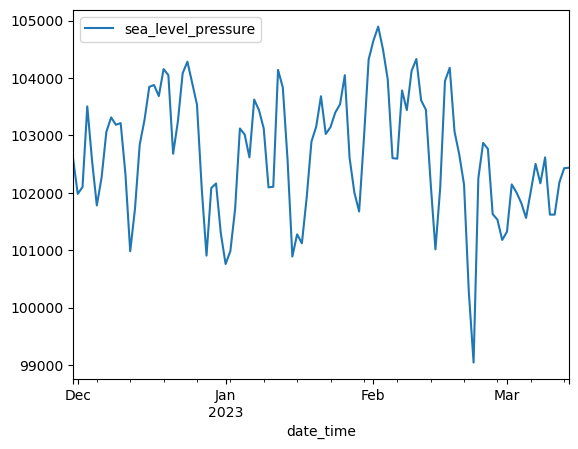

In [11]:
repr_mslp.plot()

In [12]:
# repr_ozone argument should be a subset for the three stations ["UBHSP", "QV4", "QRS"]
# and the ozone_concentration column
ozone_subdf = df[df["stid"].isin(["UBHSP", "QV4", "QRS"])][["ozone_concentration","stid"]]
repr_ozone = do_repval_ozone(ozone_subdf)
repr_ozone

,ozone_concentration
date_time,
2022-11-30 00:00:00-07:00,38.6952
2022-12-01 00:00:00-07:00,29.9756
2022-12-02 00:00:00-07:00,45.9800
2022-12-03 00:00:00-07:00,37.9800
2022-12-04 00:00:00-07:00,34.7546
...,...
2023-03-10 00:00:00-07:00,81.9000
2023-03-11 00:00:00-07:00,75.8108
2023-03-12 00:00:00-07:00,72.0376


<Axes: xlabel='date_time'>

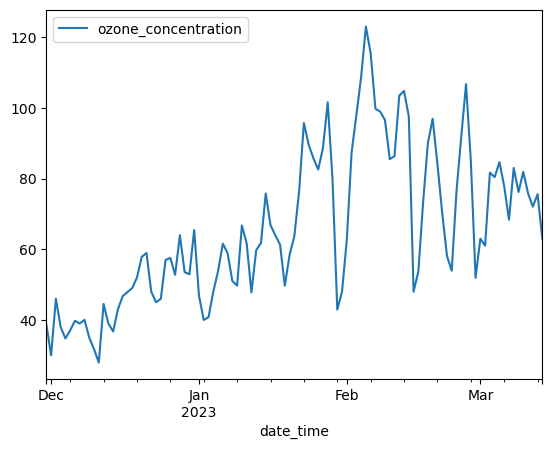

In [13]:
# Visualise repr_ozone 
repr_ozone.plot()

<Axes: xlabel='date_time'>

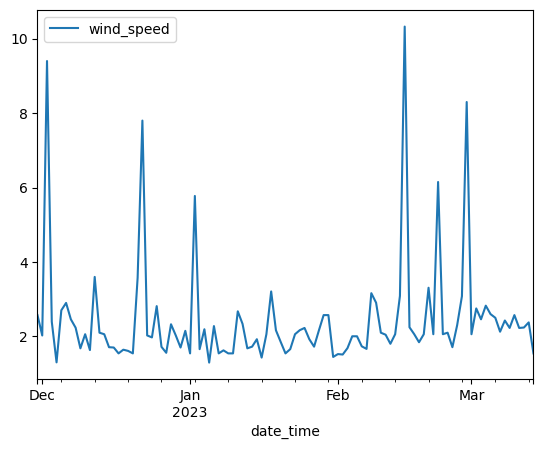

In [20]:
# How to generate wind speed? 
wind_stids = ['DURU1', 'A1622', 'SPMU1', 'QV4', 'WAXU1', 'E8302', 'KVEL', 'QRS', 'MYT5']
repr_wind = do_repval_wind(df[df["stid"].isin(wind_stids)][["wind_speed","stid"]])
repr_wind.plot()
# repr_wind

<Axes: xlabel='date_time'>

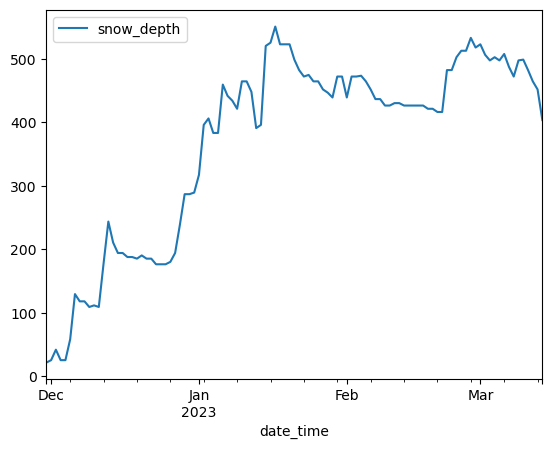

In [21]:
snow_stids = ['COOPJENU1', 'COOPFTDU1', 'COOPALMU1', 'COOPDINU1', 'COOPROSU1', 
                'COOPVELU1', 'COOPDSNU1', 'COOPOURU1', 'COOPNELU1']
repr_snow = do_repval_snow(df[df["stid"].isin(snow_stids)][["snow_depth","stid"]])
repr_snow.plot()



In [32]:
solar_stids = ["DURU1", "A1622", "SPMU1", "WAXU1"]
# solar_subset = df[df["stid"].isin(solar_stids)][["solar_radiation","stid"]]
# solar_subset

repr_solar = do_repval_solar(df[df["stid"].isin(solar_stids)][["solar_radiation","stid"]])
repr_solar

date_time
2022-12-01 00:00:00-07:00           NaN
2022-12-02 00:00:00-07:00           NaN
2022-12-03 00:00:00-07:00           NaN
2022-12-04 00:00:00-07:00           NaN
2022-12-05 00:00:00-07:00           NaN
                                ...    
2023-03-10 00:00:00-07:00    559.507361
2023-03-11 00:00:00-07:00    616.730581
2023-03-12 00:00:00-07:00    603.728327
2023-03-13 00:00:00-06:00    601.237402
2023-03-14 00:00:00-06:00    558.310058
Name: solar_radiation, Length: 104, dtype: float64

<Axes: xlabel='date_time'>

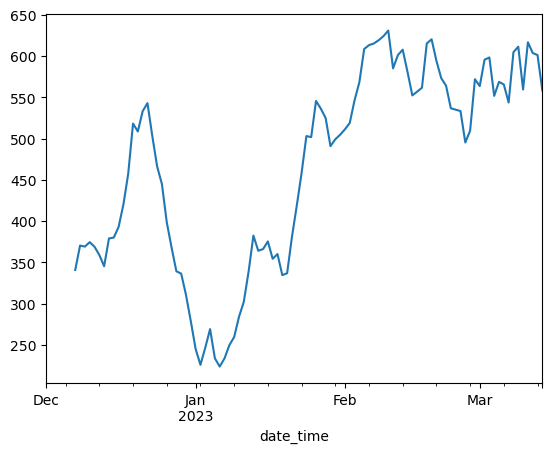

In [33]:
repr_solar.plot()
